<center>

---
Clasificador de imagénes de Tom y Jerry

---

</center>

In [1]:
!pip install tensorflow -q
!pip install visualkeras -q
!pip install albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.2 MB/s eta 0:00:00a 0:00:01


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import kagglehub
from PIL import Image
import visualkeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from os import listdir

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# Definir el tamaño de las imágenes
img_size = 224

In [4]:
def Cargar_img(directorio: str, img_size: tuple[int, int], color_mode: str):

    X, y = [], []
    class_names = listdir(directorio)
    for i, img_fold in enumerate(class_names):

        images_path = listdir(os.path.join(directorio, img_fold))
        y.extend([i]*len(images_path))
        for img_name in images_path:
            image = tf.keras.utils.load_img(
                os.path.join(directorio, img_fold, img_name),
                color_mode = color_mode,
                target_size= img_size,
                interpolation="nearest",
                keep_aspect_ratio=False,
            )

            image = tf.keras.utils.img_to_array(image, data_format="channels_last").astype(np.uint8)

            X.append(image)

    print("Clases encontradas:", class_names)
    X = np.array(X)
    y = np.array(y)

    i = np.arange(0, y.shape[0])
    np.random.shuffle(i)

    return X[i], y[i]

In [5]:
X, y = Cargar_img(
    directorio = "/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry",
    img_size = (128,128),
    color_mode = "rgb"
)

Clases encontradas: ['tom_jerry_1', 'jerry', 'tom', 'tom_jerry_0']


In [6]:
clases = ['tom_jerry_1', 'jerry', 'tom', 'tom_jerry_0']

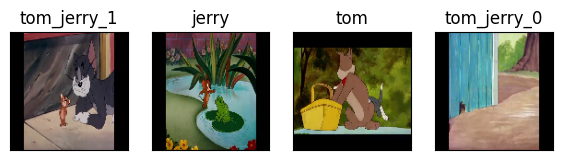

In [7]:
_, axes = plt.subplots(1, 4, figsize=(7,7))
for i in range(len(clases)):
    axes[i].imshow(X[ y == i ][0])
    axes[i].set_title(clases[i])

    axes[i].xaxis.set_tick_params(labelbottom=False)
    axes[i].yaxis.set_tick_params(labelleft=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()

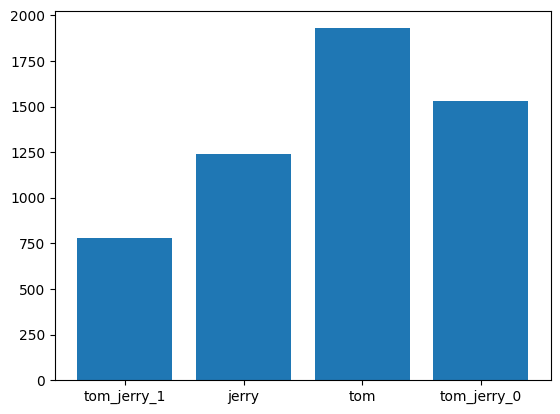

In [8]:
plt.figure()

plt.bar(clases, np.bincount(y))

plt.show()

In [9]:
X_scaled = X / 255

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, stratify=y)

In [11]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,128,3)),
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(128, 128, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(clases), activation='softmax')
])

modelo.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      29,491,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,515,588 (112.59 MB)

 Trainable params: 29,514,372 (112.59 MB)

 Non-trainable params: 1,216 (4.75 KB)

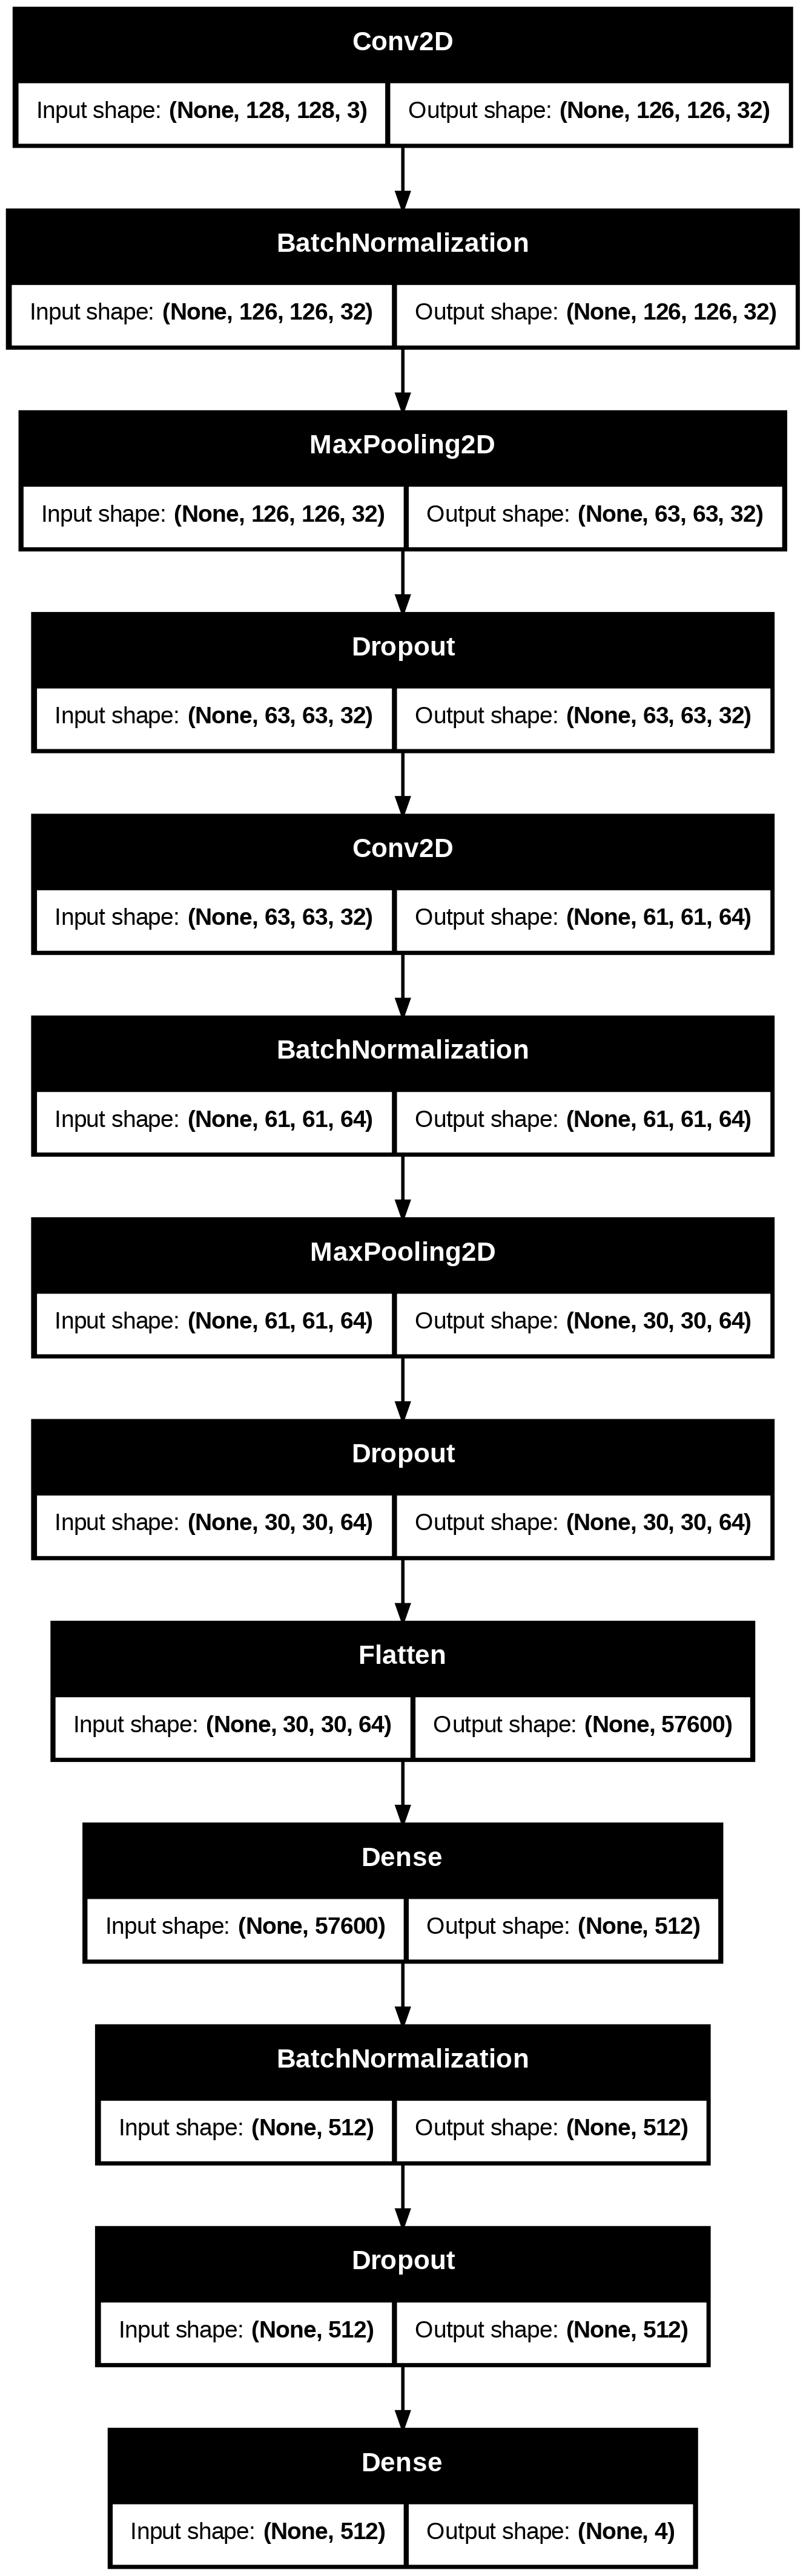

In [12]:
tf.keras.utils.plot_model(modelo, show_shapes=True)

In [13]:
train_data_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 45,    # rotar imagenes hasta 45 grados aleatoriamente
    shear_range=0.2,        # mover la imagen para formar un paralelogramo, hasta en un 20% aleatoriamente
    zoom_range=0.2,         # aplicar zoom hasta del 20% aleatoriamente
    horizontal_flip=True,   # rotar horizontalmente la imagen aleatoriamente
    validation_split=0.25   # fraccion de las imagenes que seran usadas para validar el modelo
)

In [14]:
# Compilacion
modelo.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
CB = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
]

# Entrenamiento
history = modelo.fit(
    train_data_augmenter.flow(X_train, y_train, subset="training"),
    validation_data = train_data_augmenter.flow(X_train, y_train, subset="validation"),
    epochs = 60,
    callbacks = CB,
    batch_size = 32,
    validation_batch_size = 32
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3308 - loss: 2.5826 - val_accuracy: 0.2146 - val_loss: 6.6463
Epoch 2/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.3833 - loss: 1.5455 - val_accuracy: 0.2256 - val_loss: 9.7566
Epoch 3/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.4074 - loss: 1.4247 - val_accuracy: 0.2849 - val_loss: 2.7150
Epoch 4/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.4384 - loss: 1.3533 - val_accuracy: 0.2393 - val_loss: 7.0186
Epoch 5/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.4556 - loss: 1.3022 - val_accuracy: 0.2795 - val_loss: 3.3847
Epoch 6/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.4913 - loss: 1.2059 - val_accuracy: 0.3178 - val_loss: 2.0408
Epoch 7/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.4849 - loss: 1.1673 - val_accuracy: 0.3361 - val_loss: 1.5698
Epoch 8/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.5234 - loss: 1.0963 - val

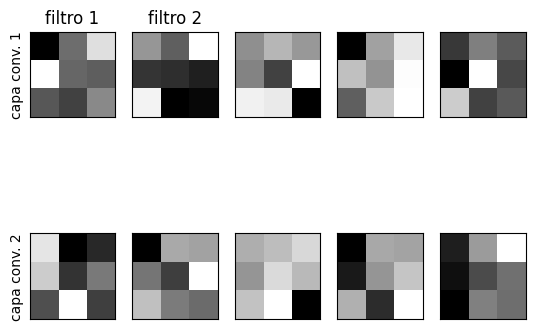

In [15]:
# filtrar capas convolucionales
conv_layers = [layer for layer in modelo.layers if "conv" in layer.name ]

np.random.seed(1)

_, axes = plt.subplots(len(conv_layers), 5)

for i, layer in enumerate(conv_layers):
    axes[i,0].set_ylabel(f"capa conv. {i+1}")
    axes[0,i].set_title(f"filtro {i+1}")

    # obtener los filtros de cada capa convolucional
    filters, biases = layer.get_weights()
    # reescalar filtros para poder ser visualizados
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # obtener 4 filtros al azar para ser visualizados
    sel = np.random.randint(0, filters.shape[-1], 5)
    filters_selected = filters[:,:,:, sel]
    filters_selected = np.moveaxis(filters_selected, -1, 0)
    filters_selected = np.mean(filters_selected, axis=3, keepdims=True)
    # filters_selected = filters_selected[:,:,:,0]
    for j, filter in enumerate(filters_selected):
        # visualizar filtro
        axes[i,j].imshow(filter, cmap="gray")

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


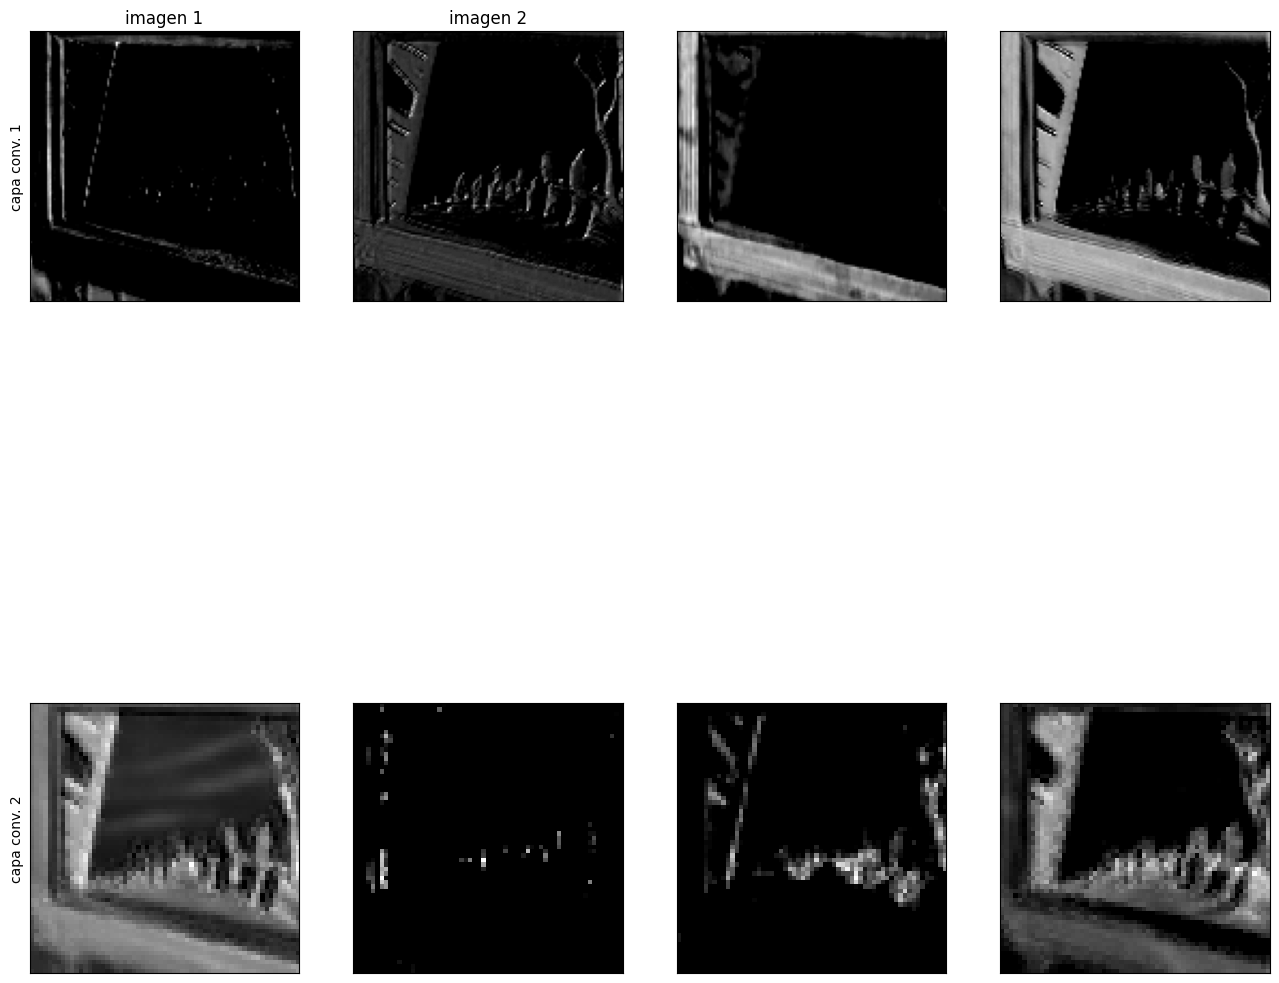

In [16]:
_, axes = plt.subplots(len(conv_layers), 4, figsize=(16,16))

np.random.seed(3)

# modelo que nos dara la salida de cada capa convolucional
vis_model = tf.keras.models.Model(
    inputs = modelo.inputs,
    outputs = [ layer.output for layer in conv_layers ]
)

# aplicar el modelo hasta cada capa convolucional
feature_maps = vis_model.predict(np.expand_dims(X_test[40], axis=0))

for i, f_map in enumerate(feature_maps):
    axes[i,0].set_ylabel(f"capa conv. {i+1}")
    axes[0,i].set_title(f"imagen {i+1}")

    # filtrar imagenes resultantes sin caracteristicas extraidas
    f_map = f_map[:,:,:, np.any(f_map[0,:,:,:] > 0, axis=(0,1)) ]

    # seleccionar 4 imagenes con el filtro aplicado para mostrar
    sel = np.random.randint(0, f_map.shape[-1], 4)
    feature_map_selected = f_map[:,:,:, sel]
    feature_map_selected = feature_map_selected[0]
    feature_map_selected = np.moveaxis(feature_map_selected, -1, 0)
    for j, image in enumerate(feature_map_selected):
        # visualizar imagen
        axes[i,j].imshow(image, cmap="gray")

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

plt.show()

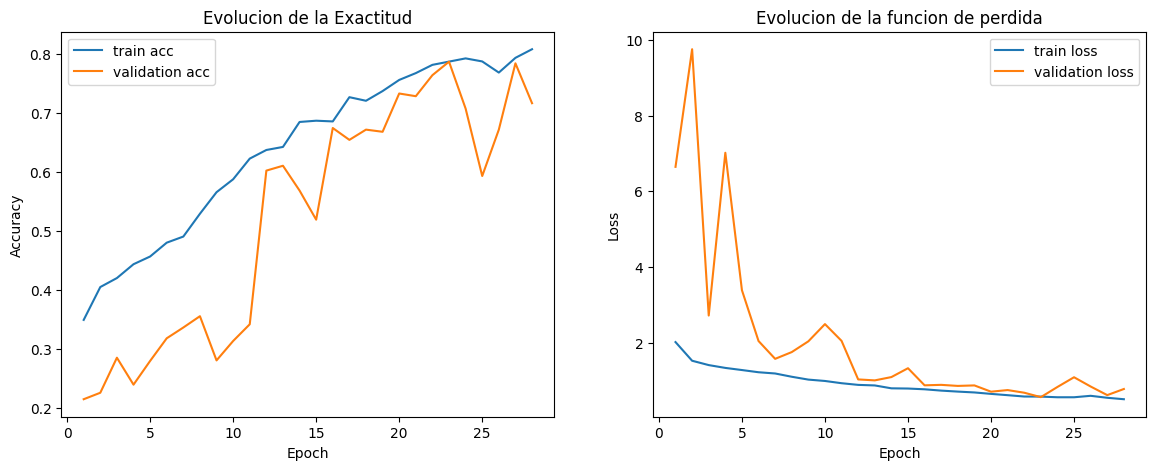

In [17]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()

In [19]:
import numpy as np
def plot_imagen_classification(modelo, imagen, clases, y_true=None):
    if len(imagen.shape) == 3:
        imagen = np.expand_dims(imagen, axis=0)

    predictions = modelo.predict(imagen)
    predicted_class = np.argmax(predictions)

    fig, (img_ax, prob_ax) = plt.subplots(1, 2, figsize=(10,3))

    img_ax.imshow(imagen[0], cmap=plt.get_cmap('gray'))

    img_ax.xaxis.set_tick_params(labelbottom=False)
    img_ax.yaxis.set_tick_params(labelleft=False)
    img_ax.set_xticks([])
    img_ax.set_yticks([])

    prob_ax.bar(clases, predictions[0], label="otras clases", color="blue")
    prob_ax.bar(clases[predicted_class], predictions[0, predicted_class], label=f"predicha ({clases[predicted_class]})", color="red")

    if y_true != None:
        prob_ax.bar(clases[y_true], predictions[0, y_true], label=f"verdadera ({clases[y_true]})", color="green")

    prob_ax.legend()
    prob_ax.set_ylabel("probabilidad")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


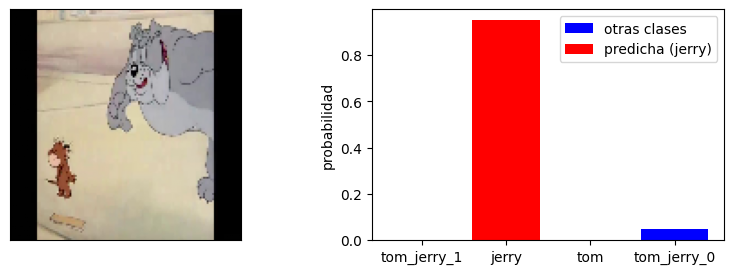

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


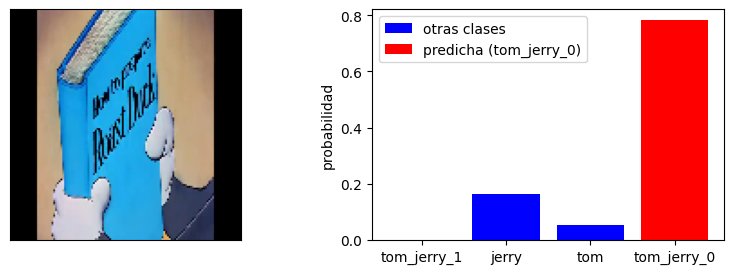

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


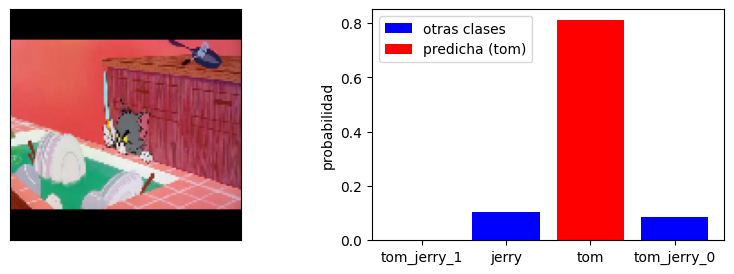

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


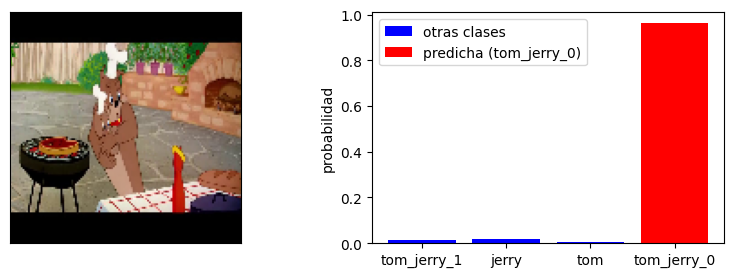

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


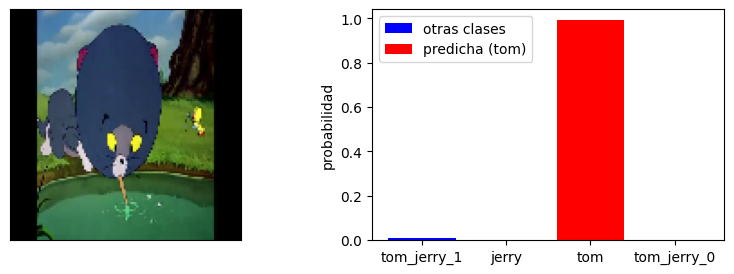

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


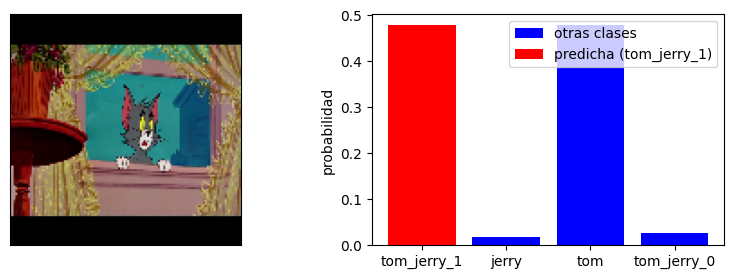

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


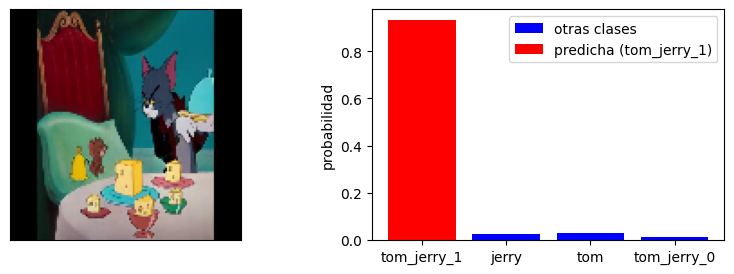

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


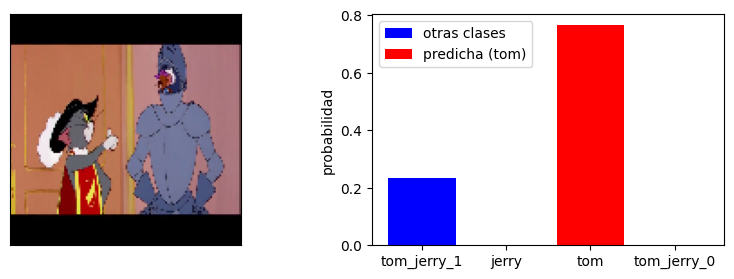

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


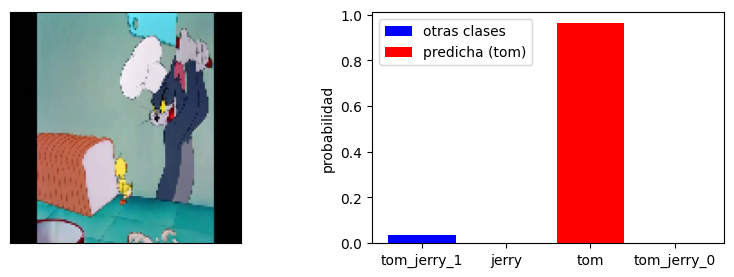

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


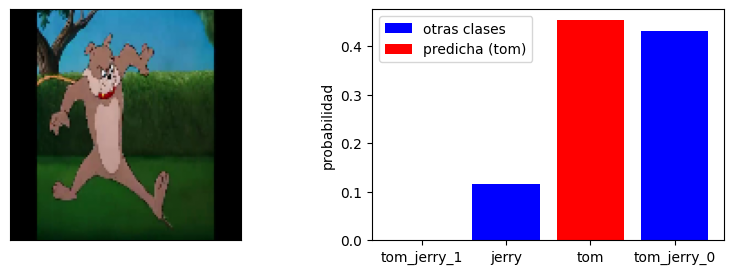

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


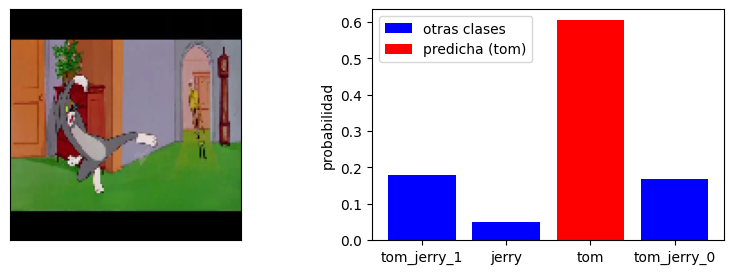

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


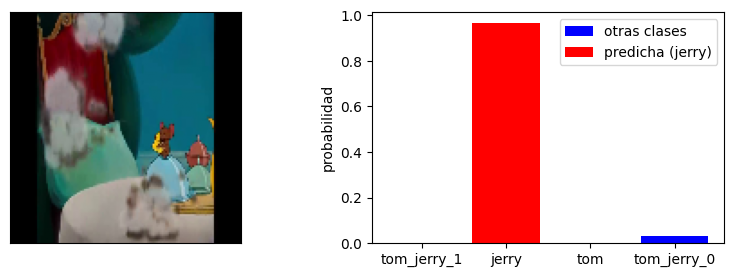

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


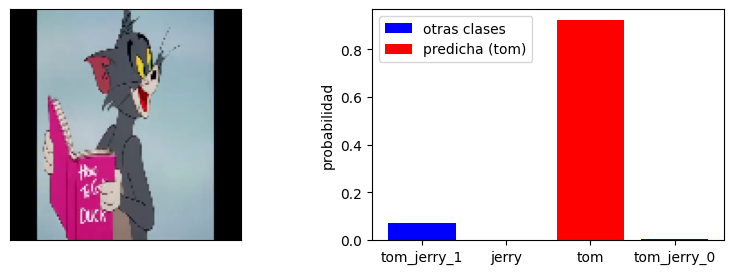

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


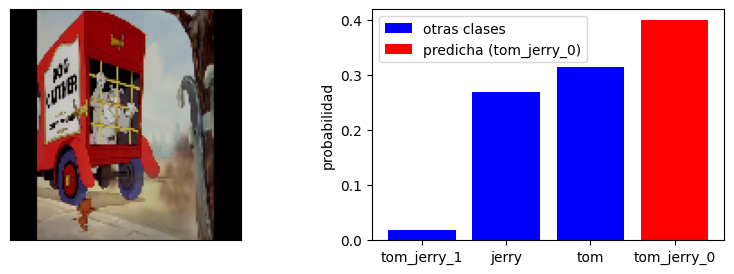

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


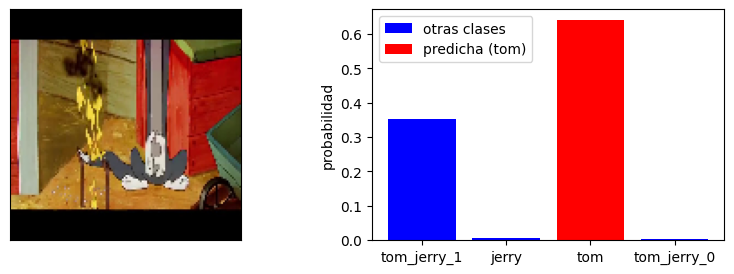

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


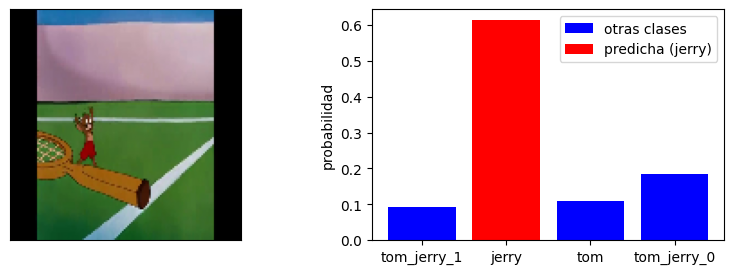

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


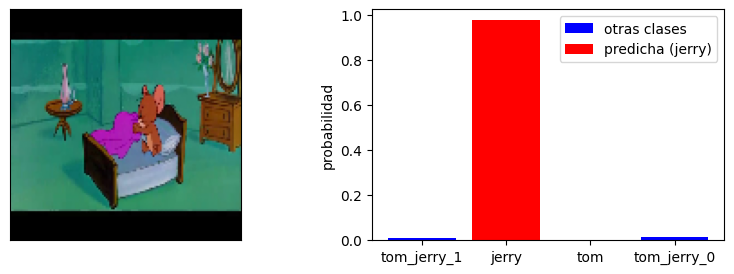

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


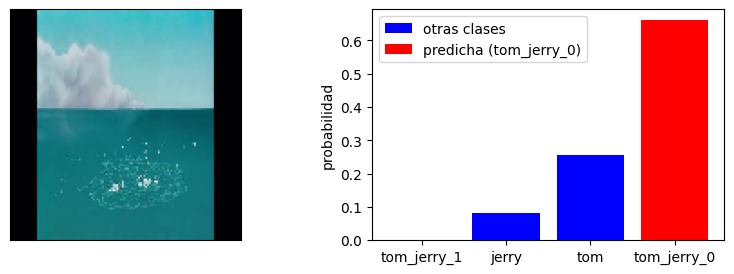

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


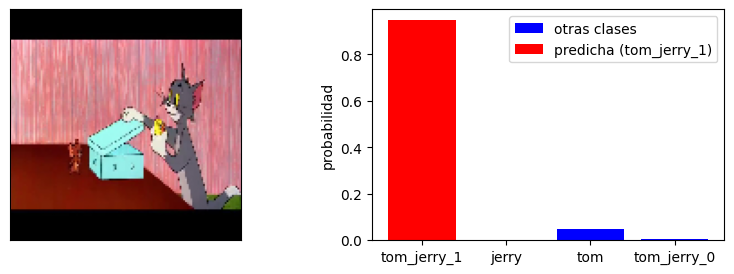

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


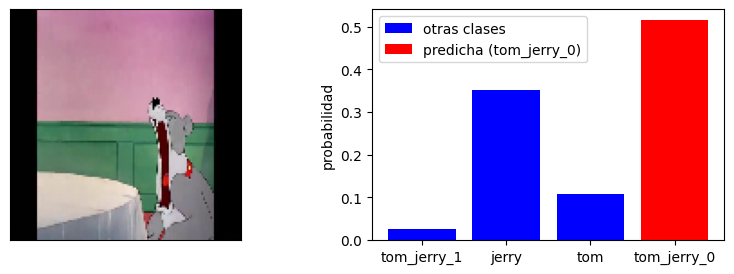

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


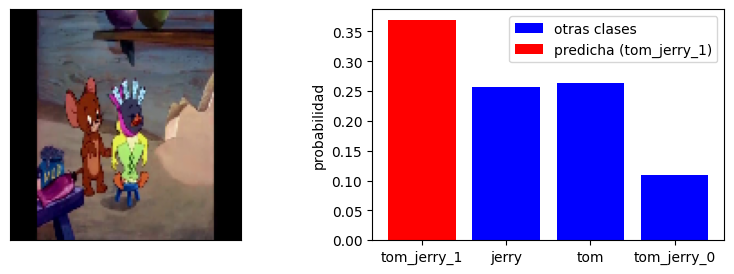

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


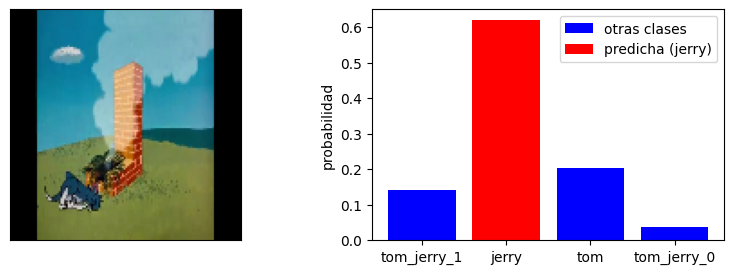

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


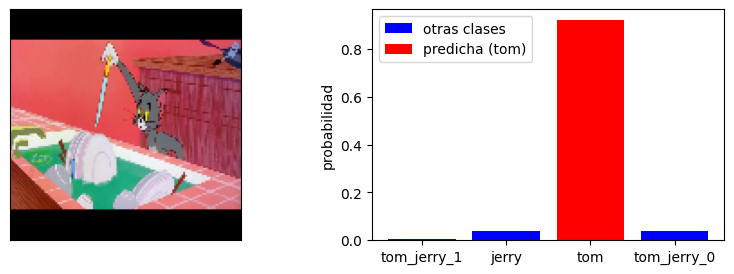

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


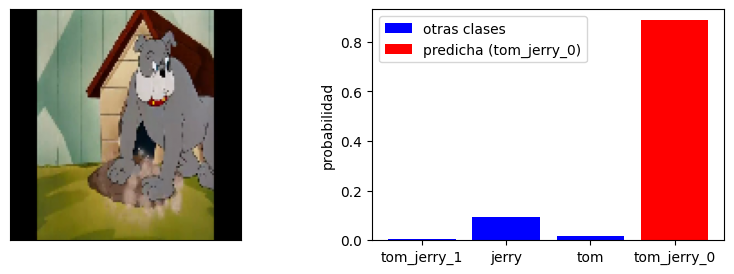

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


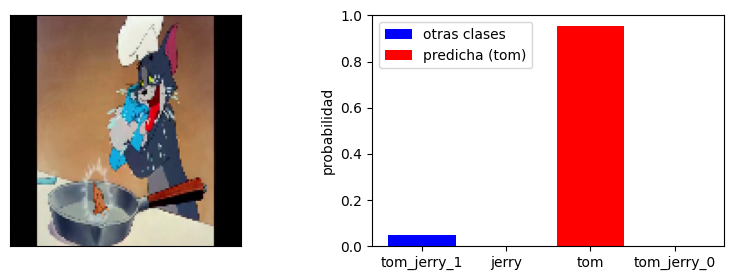

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


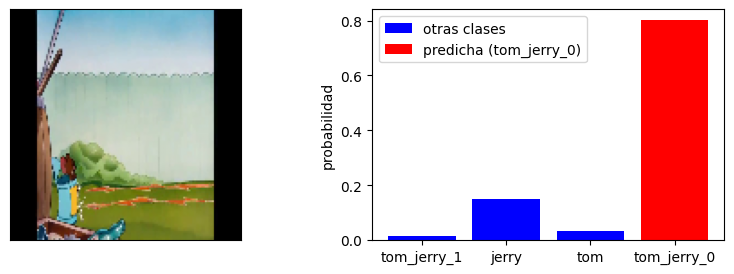

In [20]:
for i in range(100, 126):
  #print(len(x_test[i].shape))
  plot_imagen_classification(modelo, X_test[i], clases)


ENTRENAMIENTO Y VALIDACION:

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       624
           1       0.87      0.81      0.84       992
           2       0.85      0.90      0.88      1544
           3       0.82      0.85      0.84      1222

    accuracy                           0.84      4382
   macro avg       0.84      0.83      0.83      4382
weighted avg       0.84      0.84      0.84      4382


PRUEBA:

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       156
           1       0.86      0.76      0.81       248
           2       0.81      0.88      0.84       386
           3       0.79      0.85      0.82       306

    accuracy                           0.81      1096
   macro avg       0.81      0.78      0.79      1096
weighted avg       0.81      0.81      0.81      1096



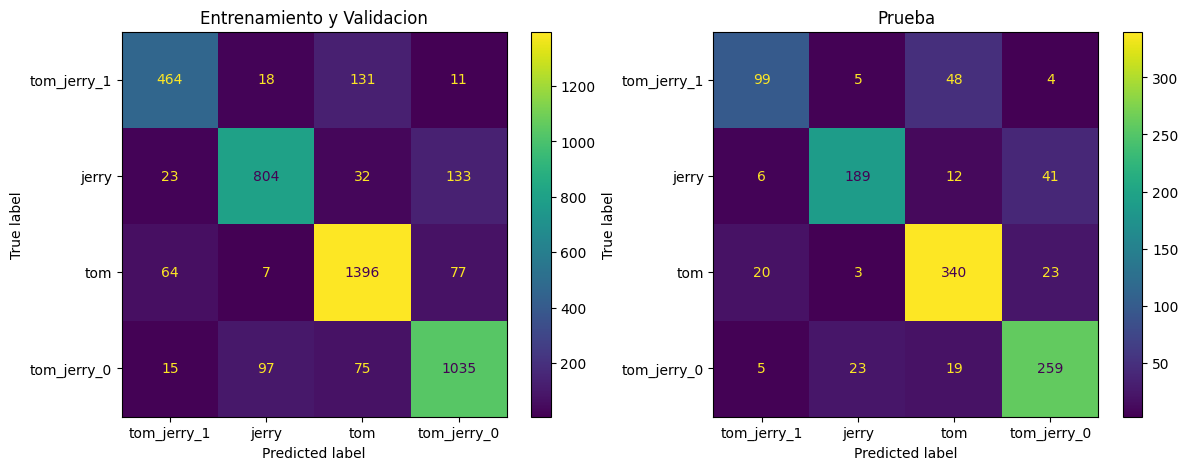

In [21]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

print("\nENTRENAMIENTO Y VALIDACION:\n")

y_pred = np.argmax(modelo.predict(X_train), axis=1)

print(classification_report(y_train, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_train,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax1
)
ax1.set_title("Entrenamiento y Validacion")

print("\nPRUEBA:\n")

y_pred = np.argmax(modelo.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax2
)
ax2.set_title("Prueba")

plt.show()